# Preserving NaN missing values with safeguards

In this example, we compare how three lossy compressors (ZFP, SZ3, and SPERR) handle missing values that are encoded as NaNs. We compress a single day (four 6h observations) of sea-only satellite observation data, where data is missing on land (static) and wherever is not currently covered by the satellites (dynamic). Finally, we apply safeguards to guarantee that NaN values are preserved.

Since the SPERR codec does not support NaN values, we replace them with zeros before encoding with SPERR.

In [1]:
import ssl

ssl._create_default_https_context = ssl._create_stdlib_context

In [2]:
from pathlib import Path

import earthkit.plots
import numcodecs.compat
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from numcodecs.abc import Codec
from numcodecs_combinators.stack import CodecStack
from numcodecs_safeguards import SafeguardsCodec
from numcodecs_wasm_sperr import Sperr
from numcodecs_wasm_sz3 import Sz3
from numcodecs_wasm_zfp_classic import ZfpClassic

In [3]:
wvpa = xr.open_dataset(
    Path() / "data" / "hoaps-c.r30.h06.wvpa.2020-08" / "data.nc",
    engine="netcdf4",
    decode_timedelta=True,
).wvpa.sel(time="2020-08-02")
wvpa

<xarray.DataArray 'wvpa' (time: 4, lat: 320, lon: 720)> Size: 4MB
[921600 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 32B 2020-08-02 ... 2020-08-02T18:00:00
  * lat      (lat) float64 3kB 79.75 79.25 78.75 78.25 ... -78.75 -79.25 -79.75
  * lon      (lon) float64 6kB -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Attributes:
    long_name:       Water Vapor Path
    standard_name:   atmosphere_water_vapor_content
    units:           kg/m^2
    C_format:        %6.2f
    FORTRAN_format:  F6.2
    comment:         1D-Var: Algorithm Theoretical Baseline Document HOAPS ve...
    cell_methods:    area: mean
    code:            3

In [4]:
vmin, vmax = int(np.floor(np.amin(wvpa))), int(np.ceil(np.amax(wvpa)))
vmin, vmax

(2, 73)

## Compressing water vapour path with lossy compressors and safeguards

We configure each compressor and the safeguards with an absolute error bound of 0.1 kg/m^2. For the safeguards, we compare (a) considering NaN values only as equal if their bit patterns match and (b) considering all NaN values as equal.

In [5]:
eb_abs = 0.1

In [6]:
zfp = ZfpClassic(mode="fixed-accuracy", tolerance=eb_abs)

wvpa_zfp_enc = zfp.encode(wvpa.values)
wvpa_zfp = wvpa.copy(deep=True, data=zfp.decode(wvpa_zfp_enc))
wvpa_zfp_cr = wvpa.nbytes / wvpa_zfp_enc.nbytes

In [7]:
zfp_sg = SafeguardsCodec(
    codec=zfp, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_zfp_sg_enc = zfp_sg.encode(wvpa.values)
wvpa_zfp_sg = wvpa.copy(deep=True, data=zfp_sg.decode(wvpa_zfp_sg_enc))
wvpa_zfp_sg_cr = wvpa.nbytes / np.asarray(wvpa_zfp_sg_enc).nbytes

In [8]:
zfp_sg_nan = SafeguardsCodec(
    codec=zfp, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_zfp_sg_nan_enc = zfp_sg_nan.encode(wvpa.values)
wvpa_zfp_sg_nan = wvpa.copy(deep=True, data=zfp_sg_nan.decode(wvpa_zfp_sg_nan_enc))
wvpa_zfp_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_zfp_sg_nan_enc).nbytes

In [9]:
sz3 = Sz3(eb_mode="abs", eb_abs=eb_abs)

wvpa_sz3_enc = sz3.encode(wvpa.values)
wvpa_sz3 = wvpa.copy(deep=True, data=sz3.decode(wvpa_sz3_enc))
wvpa_sz3_cr = wvpa.nbytes / np.asarray(wvpa_sz3_enc).nbytes

In [10]:
sz3_sg = SafeguardsCodec(
    codec=sz3, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_sz3_sg_enc = sz3_sg.encode(wvpa.values)
wvpa_sz3_sg = wvpa.copy(deep=True, data=sz3_sg.decode(wvpa_sz3_sg_enc))
wvpa_sz3_sg_cr = wvpa.nbytes / np.asarray(wvpa_sz3_sg_enc).nbytes

In [11]:
sz3_sg_nan = SafeguardsCodec(
    codec=sz3, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_sz3_sg_nan_enc = sz3_sg_nan.encode(wvpa.values)
wvpa_sz3_sg_nan = wvpa.copy(deep=True, data=sz3_sg_nan.decode(wvpa_sz3_sg_nan_enc))
wvpa_sz3_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sz3_sg_nan_enc).nbytes

In [12]:
class NaNToZero(Codec):
    def encode(self, buf):
        return np.nan_to_num(buf, nan=0, posinf=np.inf, neginf=-np.inf)

    def decode(self, buf, out=None):
        return numcodecs.compat.ndarray_copy(buf, out)

In [13]:
sperr = CodecStack(NaNToZero(), Sperr(mode="pwe", pwe=eb_abs))

wvpa_sperr_enc = sperr.encode(wvpa.values)
wvpa_sperr = wvpa.copy(deep=True, data=sperr.decode(wvpa_sperr_enc))
wvpa_sperr_cr = wvpa.nbytes / np.asarray(wvpa_sperr_enc).nbytes

In [14]:
sperr_sg = SafeguardsCodec(
    codec=sperr, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)]
)

wvpa_sperr_sg_enc = sperr_sg.encode(wvpa.values)
wvpa_sperr_sg = wvpa.copy(deep=True, data=sperr_sg.decode(wvpa_sperr_sg_enc))
wvpa_sperr_sg_cr = wvpa.nbytes / np.asarray(wvpa_sperr_sg_enc).nbytes

In [15]:
sperr_sg_nan = SafeguardsCodec(
    codec=sperr, safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)]
)

wvpa_sperr_sg_nan_enc = sperr_sg_nan.encode(wvpa.values)
wvpa_sperr_sg_nan = wvpa.copy(
    deep=True, data=sperr_sg_nan.decode(wvpa_sperr_sg_nan_enc)
)
wvpa_sperr_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sperr_sg_nan_enc).nbytes

In [16]:
sg = SafeguardsCodec(
    codec=dict(id="zero"),
    safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=False)],
)

wvpa_sg_enc = sg.encode(wvpa.values)
wvpa_sg = wvpa.copy(deep=True, data=sg.decode(wvpa_sg_enc))
wvpa_sg_cr = wvpa.nbytes / np.asarray(wvpa_sg_enc).nbytes

In [17]:
sg_nan = SafeguardsCodec(
    codec=dict(id="zero"),
    safeguards=[dict(kind="eb", type="abs", eb=eb_abs, equal_nan=True)],
)

wvpa_sg_nan_enc = sg_nan.encode(wvpa.values)
wvpa_sg_nan = wvpa.copy(deep=True, data=sg_nan.decode(wvpa_sg_nan_enc))
wvpa_sg_nan_cr = wvpa.nbytes / np.asarray(wvpa_sg_nan_enc).nbytes

## Visual comparison of the decompressed missing values

ZFP and SZ3 (v3.2, pre [#f600741](https://github.com/szcompressor/SZ3/commit/f600741d1e10248024ecfaa953690f479b3e0218)) hallucinate non-NaN values for NaNs. Since SPERR does not support NaNs and interpolates over the zero fill-value, it also hallucinates some values.

In [18]:
def plot_wvpa(
    da: xr.DataArray,
    cr,
    chart,
    title,
    compressed=False,
    nan_cr=None,
):
    import copy

    # compute the default style that earthkit.maps would apply
    source = earthkit.plots.sources.XarraySource(da)
    style = copy.deepcopy(
        earthkit.plots.styles.auto.guess_style(
            source,
            units=source.units,
        )
    )
    style._levels = earthkit.plots.styles.levels.Levels(np.linspace(vmin, vmax, 22))

    chart.quickplot(
        da.sel(time="2020-08-02T06:00"), style=style, extend="both", zorder=-11
    )
    chart.ax.set_rasterization_zorder(-10)

    if compressed:
        chart.title(
            f"{title}\n"
            + rf"$L_{{{{\infty}}}}(\hat{{{{w}}}})$={np.amax(np.abs(da - wvpa)):.02}"
        )
    else:
        chart.title(f"{title}\n")

    if compressed:
        t = chart.ax.text(
            0.95,
            0.9,
            f"x {np.round(cr, 2)}"
            + ("" if nan_cr is None else f" (x {np.round(nan_cr, 2)} for Nan=Nan)"),
            ha="right",
            va="top",
            transform=chart.ax.transAxes,
        )
        t.set_bbox(dict(facecolor="white", alpha=0.75, edgecolor="black"))

    for m in earthkit.plots.schemas.schema.quickmap_subplot_workflow:
        if m != "title":
            getattr(chart, m)()

    for m in earthkit.plots.schemas.schema.quickmap_figure_workflow:
        if m != "legend":
            getattr(chart, m)()

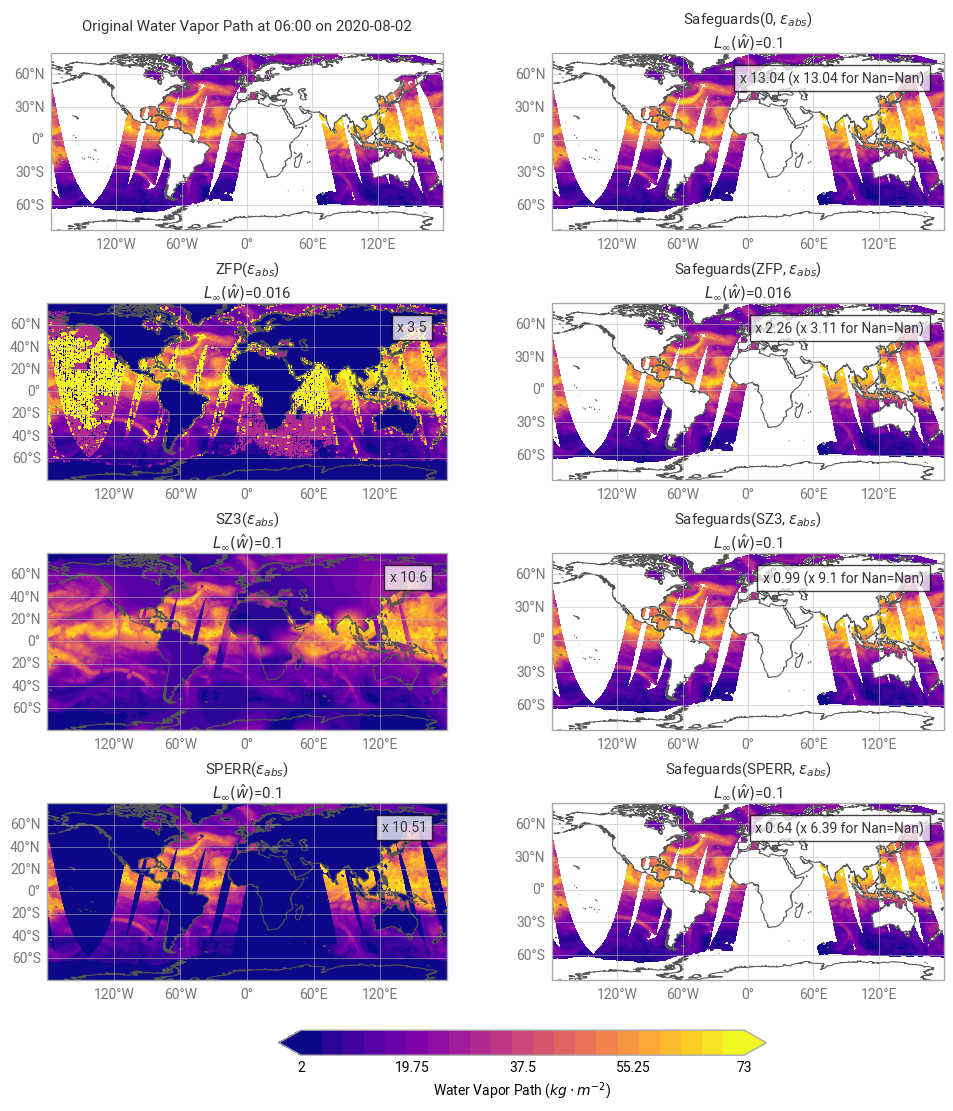

In [19]:
fig = earthkit.plots.Figure(
    size=(10, 10),
    rows=4,
    columns=2,
)

plot_wvpa(
    wvpa, 1.0, fig.add_map(0, 0), "Original {variable_name} at {time:%H:%M on %Y-%m-%d}"
)
plot_wvpa(
    wvpa_zfp,
    wvpa_zfp_cr,
    fig.add_map(1, 0),
    r"ZFP($\epsilon_{{abs}}$)",
    compressed=True,
)
plot_wvpa(
    wvpa_sz3,
    wvpa_sz3_cr,
    fig.add_map(2, 0),
    r"SZ3($\epsilon_{{abs}}$)",
    compressed=True,
)
plot_wvpa(
    wvpa_sperr,
    wvpa_sperr_cr,
    fig.add_map(3, 0),
    r"SPERR($\epsilon_{{abs}}$)",
    compressed=True,
)

plot_wvpa(
    wvpa_sg,
    wvpa_sg_cr,
    fig.add_map(0, 1),
    r"Safeguards(0, $\epsilon_{{abs}}$)",
    compressed=True,
    nan_cr=wvpa_sg_nan_cr,
)
plot_wvpa(
    wvpa_zfp_sg,
    wvpa_zfp_sg_cr,
    fig.add_map(1, 1),
    r"Safeguards(ZFP, $\epsilon_{{abs}}$)",
    compressed=True,
    nan_cr=wvpa_zfp_sg_nan_cr,
)
plot_wvpa(
    wvpa_sz3_sg,
    wvpa_sz3_sg_cr,
    fig.add_map(2, 1),
    r"Safeguards(SZ3, $\epsilon_{{abs}}$)",
    compressed=True,
    nan_cr=wvpa_sz3_sg_nan_cr,
)
plot_wvpa(
    wvpa_sperr_sg,
    wvpa_sperr_sg_cr,
    fig.add_map(3, 1),
    r"Safeguards(SPERR, $\epsilon_{{abs}}$)",
    compressed=True,
    nan_cr=wvpa_sperr_sg_nan_cr,
)

ax = plt.axes((0.05, -0.05, 0.95, 0.025))
fig.legend(ax=ax, ticks=np.linspace(vmin, vmax, 5), extend="both")

fig.save("nan.pdf")
fig.show()